In [125]:
### Regressions Ridge et Lasso avec le package glmnet
### 25 septembre 2019
### Jeremy L Hour

library("MASS")
library("glmnet")

# fonctions utilisateur
source("functions/DataSim.R") 

# 1. Simulation des donnees
set.seed(12071990)
n = 2000
data = DataSim(n, p=20, Ry= .2, Intercept=F)
ytrain = data$y[1:(n/2)]; Xtrain = data$X[1:(n/2),]
ytest  = data$y[-(1:(n/2))]; Xtest = data$X[-(1:(n/2)),]

Warning message in cst * gamma:
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.
”Warning message in cst * b:
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.
”

In [126]:
### 2. Estimateurs

### A. MCO
mco = lm(ytrain ~ Xtrain)

# calcul de l'erreur sur le jeu de test
mco.hat = predict(mco,as.data.frame(Xtest))
print(paste("Erreur de test MCO: ",mean((ytest-mco.hat)^2)))

[1] "Erreur de test MCO:  1.90263773442491"


[1] "Nombre de coefficients nuls:  0"


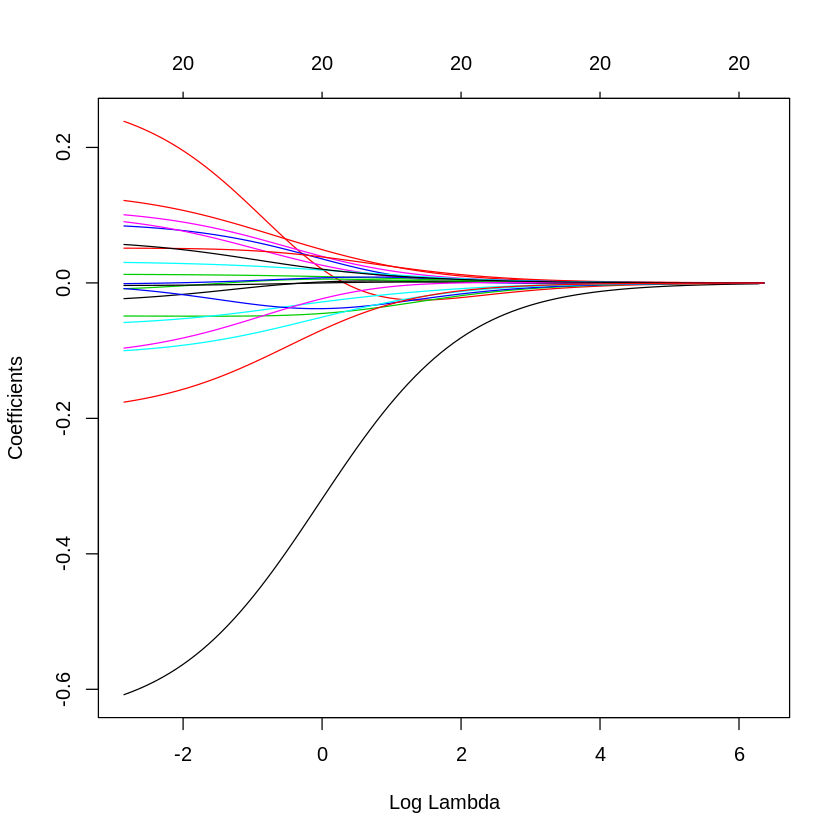

In [127]:
### B. Ridge regression (alpha=0)
Ridge = glmnet(Xtrain,ytrain, family="gaussian",alpha=0)

# Ridge$beta est une matrice où chaque colonne collecte l'estimateur Ridge pour une valeur donnee de lambda
# Prenons une valeur arbitraire
bRidge = c(Ridge$beta[,6])
print(paste("Nombre de coefficients nuls: ",sum(bRidge == 0)))
# aucun coefficient n'est strictement nul

# le package glmnet permet de visualiser la trajectoire des coefficients a mesure que lambda croit
plot(Ridge, xvar="lambda")

In [128]:
# Mise en oeuvre de la validation croisee pour choisir lambda
# a. de facon automatique avec le package
cv.ridge = cv.glmnet(Xtrain,ytrain, family="gaussian",alpha=0,nfolds=5)
print(paste("Lambda CV = ",cv.ridge$lambda.min))

ridge.hat = predict(cv.ridge,Xtest)
print(paste("Erreur de test Ridge: ",mean((ytest-ridge.hat)^2)))

# b. de facon artisanale (pour bien comprendre la validation croisee)
K = 5
lambda.set = c(seq(.001,1,by=.01),seq(1.1,100,by=5))
lambda.set = sort(lambda.set,decreasing=T)

cv.group = sample(1:K,size=n/2,replace=T)
cv.error = matrix(nrow=K, ncol=length(lambda.set))
for(k in 1:K){
    yk = ytrain[cv.group == k]; ynk = ytrain[cv.group != k]
    Xk = Xtrain[cv.group == k,]; Xnk = Xtrain[cv.group != k,]
    
    # calcul sur les "nk"
    ridge = glmnet(Xnk,ynk, family="gaussian",alpha=0,lambda=lambda.set)
    
    # prediction sur les "k"
    ridge.hat = predict(ridge,Xk)
    
    # calcul de l'erreur
    cv.error[k,] = mapply(function(d) sum((yk-ridge.hat[,d])^2),1:ncol(ridge.hat))
}

# on aggrege les erreurs et on calcule le lambda optimal
cv.error = apply(cv.error,2,sum)
lambda.cv = lambda.set[which(cv.error==min(cv.error))]
print(paste("Lambda CV à la main = ",lambda.cv))

[1] "Lambda CV =  0.0696360271375196"
[1] "Erreur de test Ridge:  1.10808116094313"
[1] "Lambda CV à la main =  0.051"


[1] "Nombre de coefficients nuls:  19"
[1] "Lambda CV Lasso =  0.0289353870841275"


Warning message in ytest - ridge.hat:
“longer object length is not a multiple of shorter object length”

[1] "Erreur de test Lasso:  1.56460647222332"


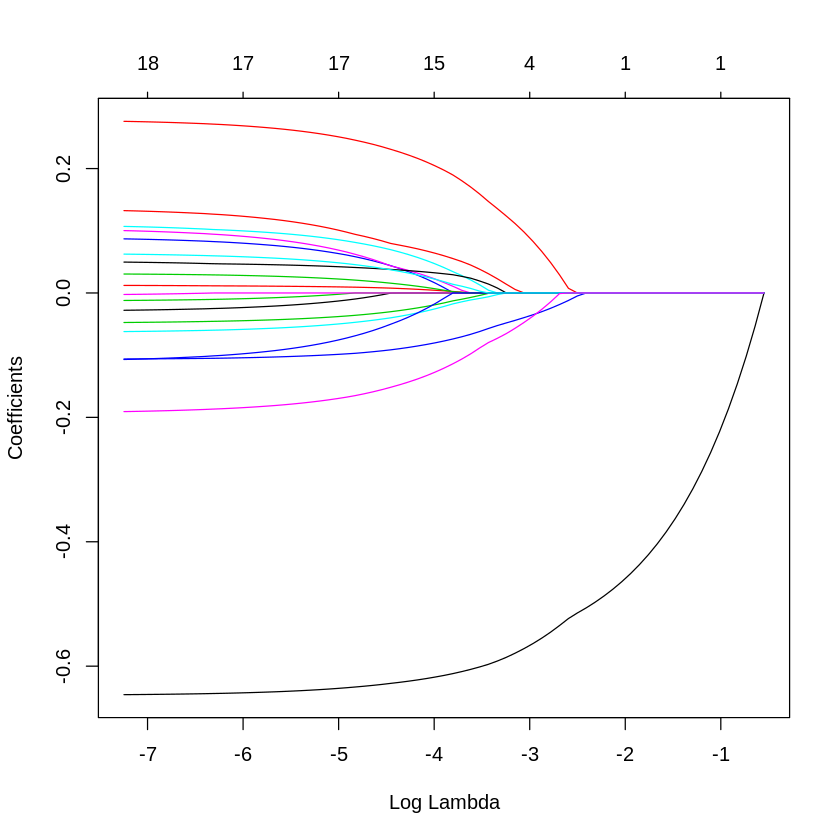

In [129]:
### C. Lasso regression (alpha=1)
lasso = glmnet(Xtrain,ytrain, family="gaussian",alpha=1)

# Prenons une valeur arbitraire
blasso = c(lasso$beta[,6])
print(paste("Nombre de coefficients nuls: ",sum(blasso == 0)))
# plusieurs coefficients sont nuls

# on constate egalement que ce n'est pas le meme profil de regularisation
plot(lasso, xvar="lambda")

# validation croisee pour le choxi du lambda
cv.lasso = cv.glmnet(Xtrain,ytrain, family="gaussian",alpha=1,nfolds=5)
print(paste("Lambda CV Lasso = ",cv.lasso$lambda.min))

lasso.hat = predict(cv.lasso,Xtest)
print(paste("Erreur de test Lasso: ",mean((ytest-ridge.hat)^2)))